In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from dataset_contour import Thyroid_Dataset
from model import Eff_Unet
from HarDMSEG import HarDMSEG
from loss_metric import DiceLoss, IOU_score, StructureLoss
from LightMed.model.LightMed import LightMed
from PMFSNet.lib.models.PMFSNet import PMFSNet
from PMFSNet.lib.models.PMFSNet_FFT import PMFSNet_FFT
import torchvision.transforms.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as tx
from hybrid_model_v3_contour import HybridSegModel_contour

In [5]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [21]:
image_size = 128
batch_size = 64
def test_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
train_dataset = Thyroid_Dataset("train_v2.csv", transform = test_augmentation, image_size = image_size)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

test_dataset = Thyroid_Dataset("test_v2.csv", transform = test_augmentation, image_size = image_size, return_from_dataset = True, crop_DDTI = True, histo_match = False)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size)

image, mask, contour, seg_typem, from_dataset = next(iter(test_dataloader))
image = image
mask = mask

In [22]:
print("std : ", torch.std(image))
print("unique : ", torch.unique(mask))
print("unique : ", torch.unique(contour))

std :  tensor(1.0000)
unique :  tensor([0., 1.])
unique :  tensor([0., 1.])


In [23]:
def average_mask_contour(mask_preds, contour_preds, weight_mask=0.7, threshold=0.5):
    prob_mask = torch.sigmoid(mask_preds)
    prob_contour = torch.sigmoid(contour_preds)

    combined = weight_mask * prob_mask + (1 - weight_mask) * prob_contour
    return (combined > threshold).float()  # shape: (B, 1, H, W)

In [24]:
# Only calculate nodule loss, IOU, DICE, because there is no gland data in the testing set
def val(dataloader, model, image_loss_fn_nodule, contour_loss_fn_nodule, device):
    total_loss = 0
    DDTI_image_total_loss = 0
    TN3K_image_total_loss = 0
    DDTI_contour_total_loss = 0
    TN3K_contour_total_loss = 0
    
    total_IOU = 0
    DDTI_total_IOU = 0
    TN3K_total_IOU = 0
    
    total_DICE = 0
    DDTI_total_DICE = 0
    TN3K_total_DICE = 0

    model.eval()
    model.to(device)
    for image, mask, contour, seg_type, from_dataset in tqdm(dataloader):
        image, mask, contour, seg_type = image.to(device), mask.to(device), contour.to(device), seg_type.to(device)
        image_pred, contour_pred = model(image)
                
        nodule_image_pred = image_pred[:, 0:1][seg_type==1]
        nodule_contour_pred = contour_pred[:, 0:1][seg_type==1]

        nodule_image_mask = mask[seg_type==1]
        nodule_contour_mask = contour[seg_type==1]



        DDTI_nodule_image_output = nodule_image_pred[from_dataset==1]
        TN3K_nodule_image_output = nodule_image_pred[from_dataset==3]

        DDTI_nodule_image_mask = nodule_image_mask[from_dataset==1]
        TN3K_nodule_image_mask = nodule_image_mask[from_dataset==3]

        DDTI_nodule_contour_output = nodule_contour_pred[from_dataset==1]
        TN3K_nodule_contour_output = nodule_contour_pred[from_dataset==3]

        DDTI_nodule_contour_mask = nodule_contour_mask[from_dataset==1]
        TN3K_nodule_contour_mask = nodule_contour_mask[from_dataset==3]

        # get image loss
        DDTI_nodule_image_loss = image_loss_fn_nodule(DDTI_nodule_image_output, DDTI_nodule_image_mask)
        TN3K_nodule_image_loss = image_loss_fn_nodule(TN3K_nodule_image_output, TN3K_nodule_image_mask)
        
        # get contour loss 
        DDTI_nodule_contour_loss = contour_loss_fn_nodule(DDTI_nodule_contour_output, DDTI_nodule_contour_mask)
        TN3K_nodule_contour_loss = contour_loss_fn_nodule(TN3K_nodule_contour_output, TN3K_nodule_contour_mask)


        nodule_loss = DDTI_nodule_image_loss + TN3K_nodule_image_loss + DDTI_nodule_contour_loss + TN3K_nodule_contour_loss
    
        # do post-process with contour and mask
        sig_DDTI_nodule_image_output = torch.sigmoid(DDTI_nodule_image_output)
        sig_DDTI_nodule_contour_output = torch.sigmoid(DDTI_nodule_contour_output)
        refined_DDTI_nodule_image_output = average_mask_contour(sig_DDTI_nodule_image_output, sig_DDTI_nodule_contour_output)

        sig_TN3K_nodule_image_output = torch.sigmoid(TN3K_nodule_image_output)
        sig_TN3K_nodule_contour_output = torch.sigmoid(TN3K_nodule_contour_output)
        refined_TN3K_nodule_image_output = average_mask_contour(sig_TN3K_nodule_image_output, sig_TN3K_nodule_contour_output)
        
        # get IOU
        DDTI_IOU = IOU_score(refined_DDTI_nodule_image_output, DDTI_nodule_image_mask)
        TN3K_IOU = IOU_score(refined_TN3K_nodule_image_output, TN3K_nodule_image_mask)

        IOU = (DDTI_IOU + TN3K_IOU) / 2

        # get DICE
        dice_loss = DiceLoss()
        DDTI_DICE = 1 - dice_loss(refined_DDTI_nodule_image_output, DDTI_nodule_image_mask)
        TN3K_DICE = 1 - dice_loss(refined_TN3K_nodule_image_output, TN3K_nodule_image_mask)

        DICE = (DDTI_DICE + TN3K_DICE) / 2
        

        total_loss += nodule_loss.item()
        DDTI_image_total_loss += DDTI_nodule_image_loss.item()
        TN3K_image_total_loss += TN3K_nodule_image_loss.item()
        DDTI_contour_total_loss += DDTI_nodule_contour_loss.item()
        TN3K_contour_total_loss += TN3K_nodule_contour_loss.item()
        
        total_IOU += IOU.item()
        DDTI_total_IOU += DDTI_IOU.item()
        TN3K_total_IOU += TN3K_IOU.item()
        
        total_DICE += DICE.item()
        DDTI_total_DICE += DDTI_DICE.item()
        TN3K_total_DICE += TN3K_DICE.item()
    return total_loss/len(dataloader), total_IOU/len(dataloader), total_DICE/len(dataloader), DDTI_image_total_loss/len(dataloader), DDTI_contour_total_loss/len(dataloader), DDTI_total_IOU/len(dataloader), DDTI_total_DICE/len(dataloader), TN3K_image_total_loss/len(dataloader), TN3K_contour_total_loss/len(dataloader),TN3K_total_IOU/len(dataloader), TN3K_total_DICE/len(dataloader), 




In [14]:

inference_name = "test"
model =  HybridSegModel_contour(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
checkpoint = torch.load(f"models/{inference_name}/best_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

In [16]:
image_loss_fn_nodule = StructureLoss()
image_loss_fn_gland = StructureLoss()

contour_loss_fn_nodule = DiceLoss()
contour_loss_fn_gland = DiceLoss()
total_loss_val, total_IOU_val, total_DICE_val, DDTI_image_total_loss_val, DDTI_contour_total_loss_val, DDTI_total_IOU_val, DDTI_total_DICE_val, TN3K_image_total_loss_val, TN3K_contour_total_loss_val, TN3K_total_IOU_val, TN3K_total_DICE_val = val(test_dataloader, model, image_loss_fn_nodule, contour_loss_fn_gland, "cpu")
print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")
print(f"DDTI val image loss : {DDTI_image_total_loss_val}, DDTI val IOU : {DDTI_total_IOU_val}, DDTI val DICE : {DDTI_total_DICE_val}")
print(f"TN3K val image loss : {TN3K_image_total_loss_val}, TN3K val IOU : {TN3K_total_IOU_val}, TN3K val DICE : {TN3K_total_DICE_val}")



100%|██████████| 20/20 [00:32<00:00,  1.63s/it]

val loss : 4.090100216865539, val IOU : 0.1670155182480812, val DICE : 0.27049472332000735
DDTI val image loss : 1.1957354426383973, DDTI val IOU : 0.1470996502786875, DDTI val DICE : 0.2444012403488159
TN3K val image loss : 1.1720109224319457, TN3K val IOU : 0.18693138733506204, TN3K val DICE : 0.29658820629119875


# Show train

In [31]:
inference_name = "test"
model =  HybridSegModel_contour(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
checkpoint = torch.load(f"models/{inference_name}/best_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [32]:
image, mask, contour, seg_type = next(iter(train_dataloader))
model.to("cpu")
image_pred, contour_pred = model(image)

In [33]:
nodule_image_pred = image_pred[:, 0:1][seg_type==1]
gland_image_pred = image_pred[:, 1:2][seg_type==2]
nodule_image_mask = mask[seg_type==1]
gland_image_mask = mask[seg_type==2]

nodule_contour_pred = contour_pred[:, 0:1][seg_type==1]
gland_contour_pred = contour_pred[:, 1:2][seg_type==2]
nodule_contour_mask = contour[seg_type==1]
gland_contour_mask = contour[seg_type==2]

In [34]:
sig_nodule_image_pred = torch.sigmoid(nodule_image_pred)
sig_nodule_contour_pred = torch.sigmoid(nodule_contour_pred)
refined_mask = average_mask_contour(nodule_image_pred, nodule_contour_pred)
print(refined_mask.shape)

torch.Size([31, 1, 128, 128])


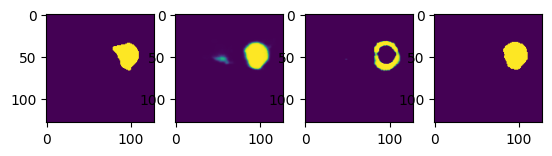

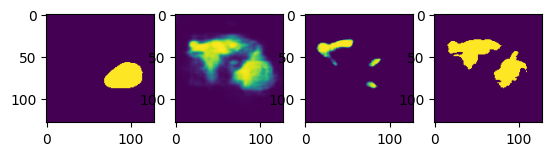

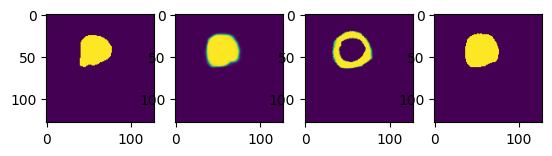

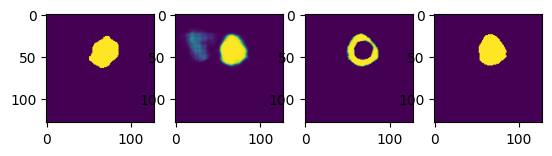

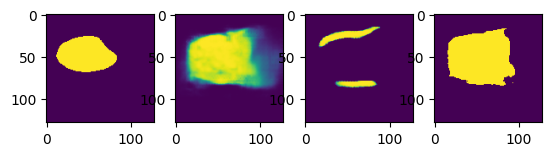

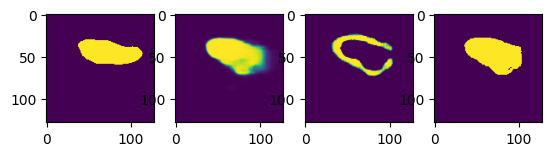

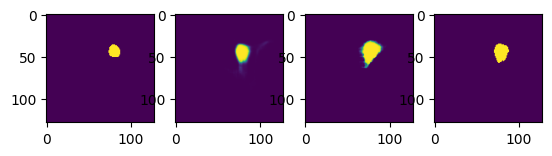

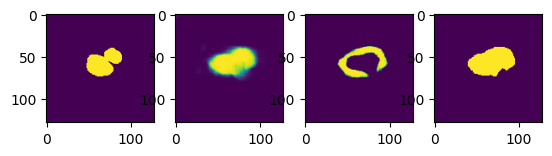

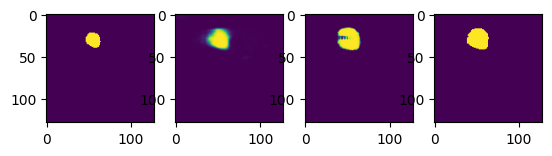

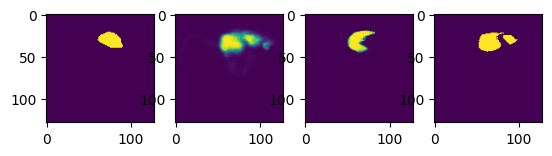

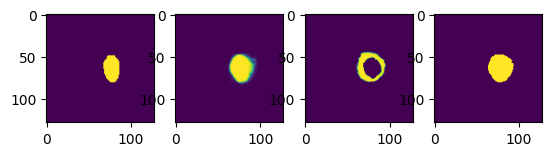

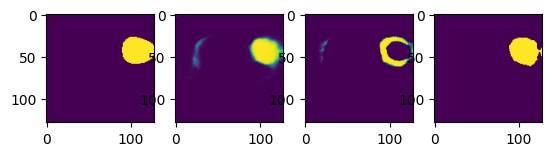

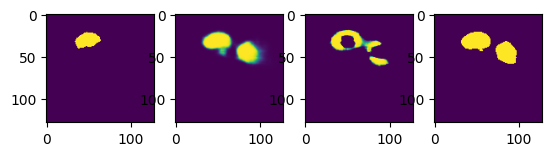

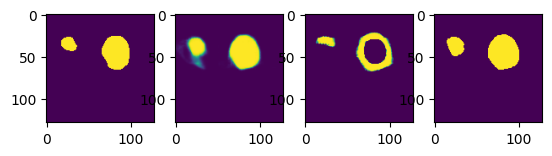

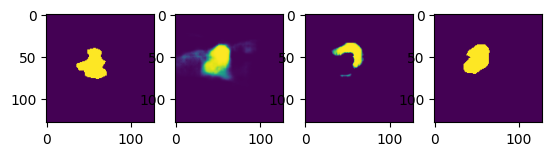

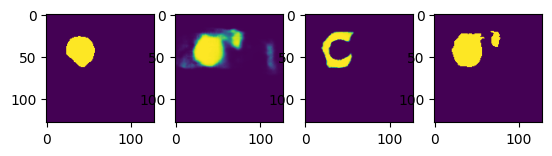

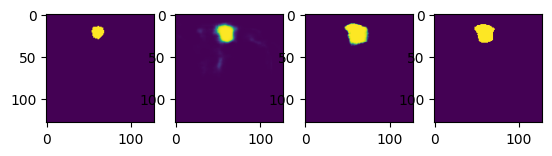

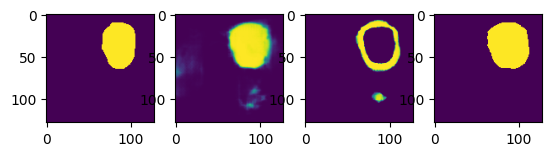

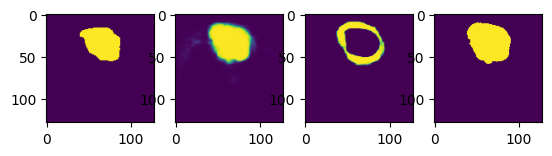

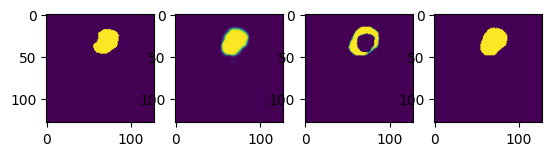

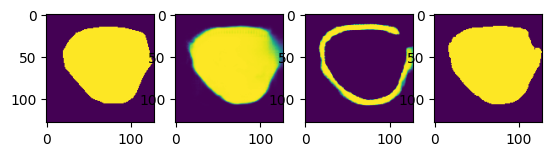

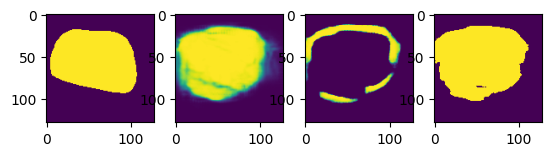

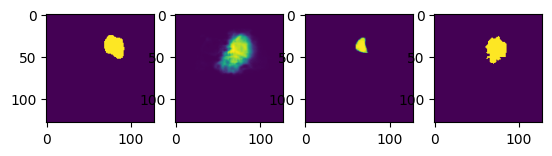

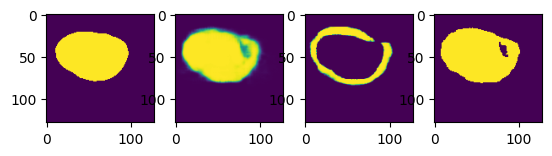

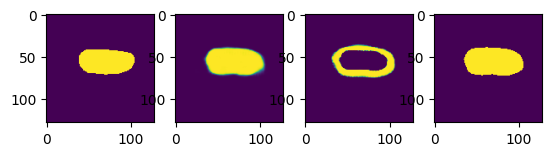

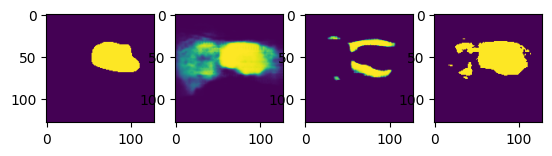

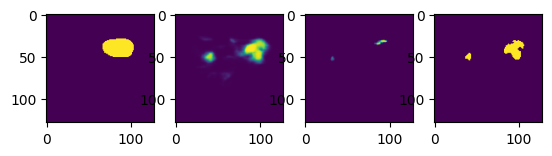

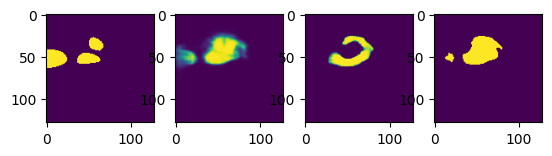

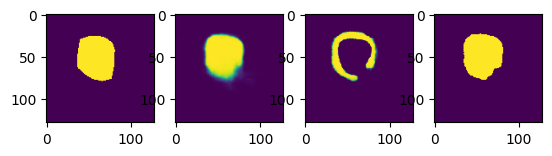

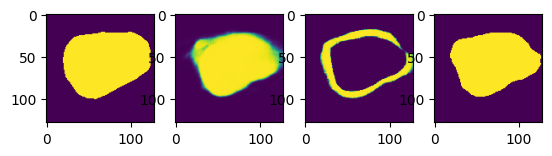

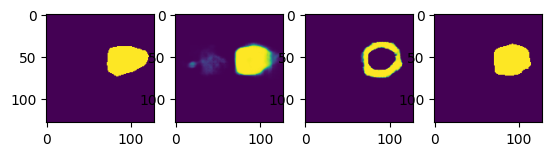

In [45]:
for i in range(nodule_image_mask.shape[0]):
    index = i
    plt.subplot(1,4,1)
    plt.imshow(nodule_image_mask[index][0].detach().cpu().numpy())
    plt.subplot(1,4,2)
    plt.imshow(sig_nodule_image_pred[index][0].detach().cpu().numpy())
    plt.subplot(1,4,3)
    plt.imshow(sig_nodule_contour_pred[index][0].detach().cpu().numpy())
    plt.subplot(1,4,4)
    plt.imshow(refined_mask[index][0].detach().cpu().numpy())
    plt.show()

# Show test

In [46]:
inference_name = "test"
model =  HybridSegModel_contour(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
checkpoint = torch.load(f"models/{inference_name}/best_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [48]:
image, mask, contour, seg_type, from_dataset = next(iter(test_dataloader))
model.to("cpu")
image_pred, contour_pred = model(image)

In [49]:
nodule_image_pred = image_pred[:, 0:1][seg_type==1]
gland_image_pred = image_pred[:, 1:2][seg_type==2]
nodule_image_mask = mask[seg_type==1]
gland_image_mask = mask[seg_type==2]

nodule_contour_pred = contour_pred[:, 0:1][seg_type==1]
gland_contour_pred = contour_pred[:, 1:2][seg_type==2]
nodule_contour_mask = contour[seg_type==1]
gland_contour_mask = contour[seg_type==2]

In [50]:
sig_nodule_image_pred = torch.sigmoid(nodule_image_pred)
sig_nodule_contour_pred = torch.sigmoid(nodule_contour_pred)
refined_mask = average_mask_contour(nodule_image_pred, nodule_contour_pred)
print(refined_mask.shape)

torch.Size([64, 1, 128, 128])


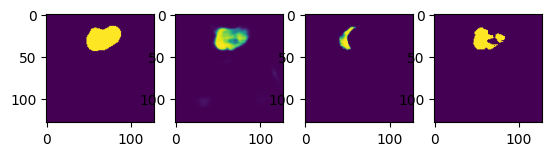

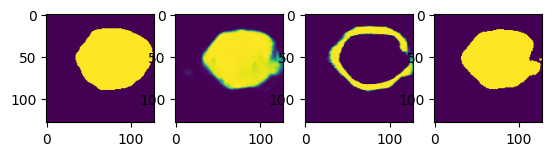

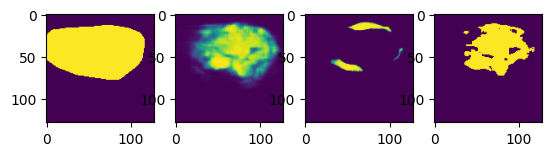

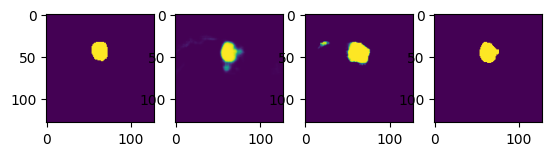

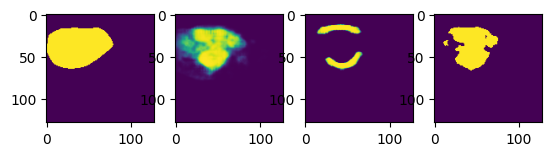

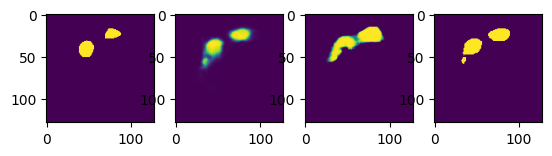

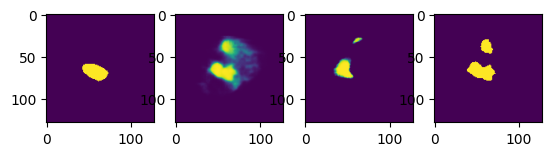

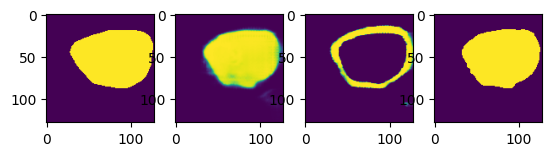

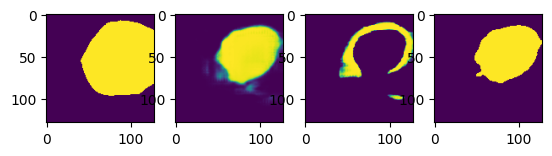

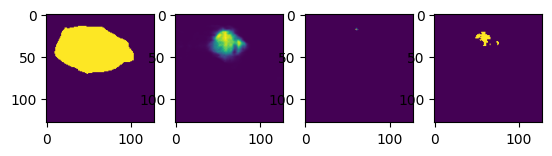

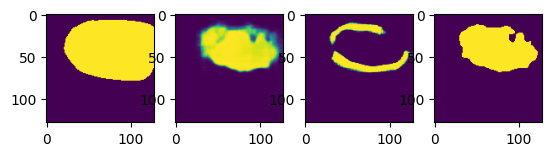

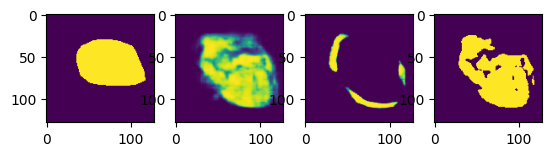

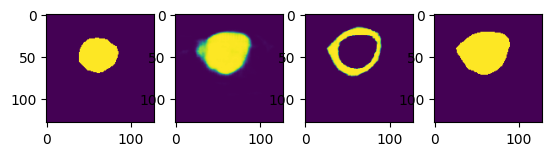

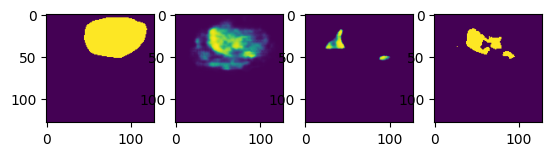

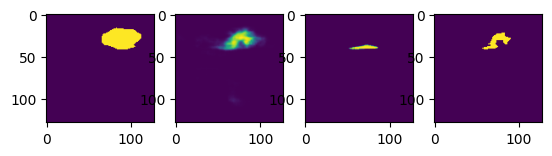

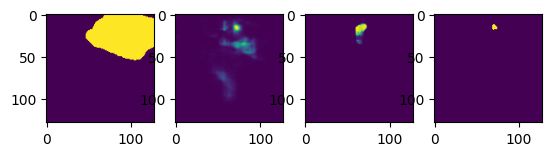

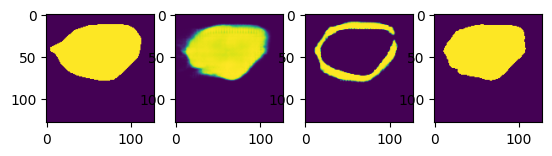

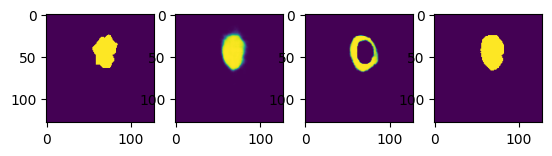

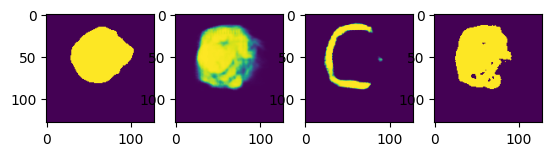

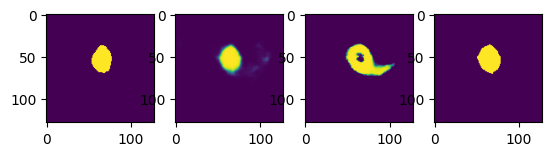

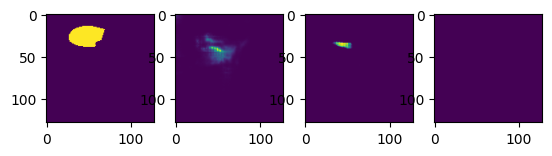

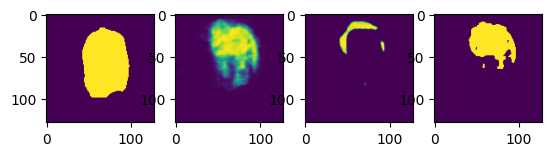

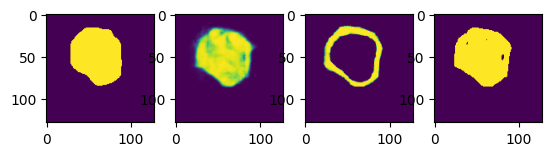

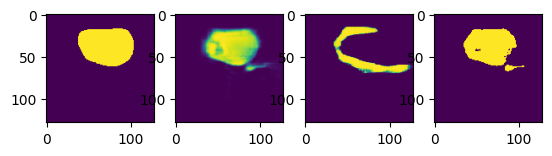

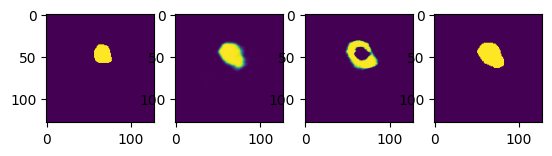

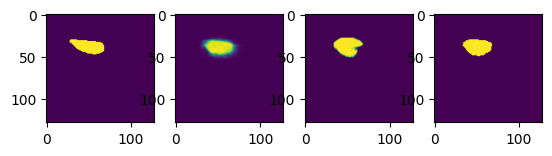

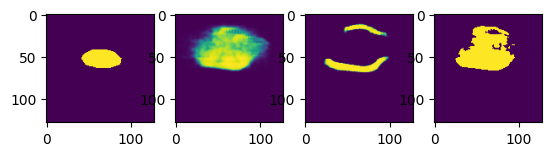

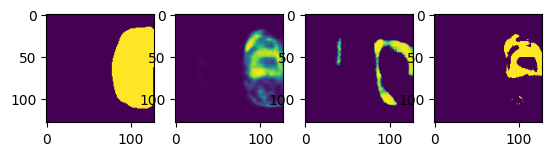

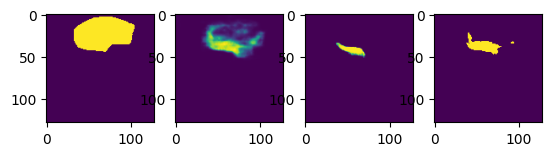

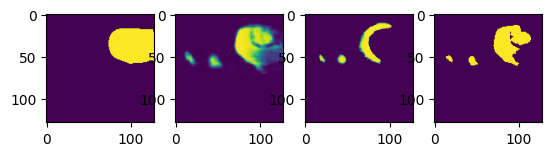

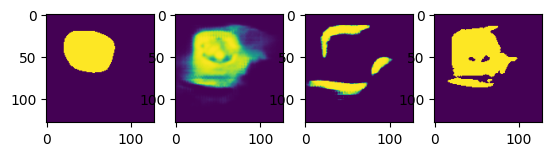

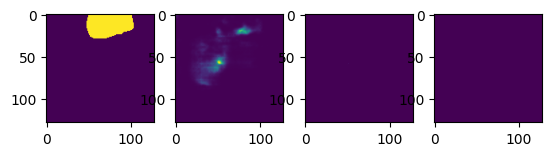

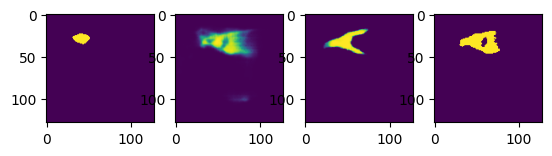

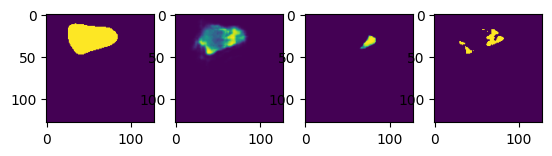

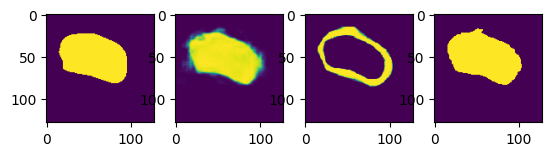

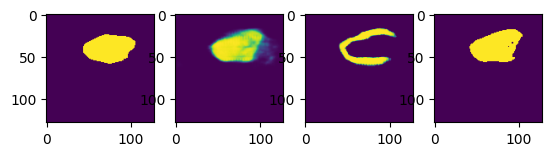

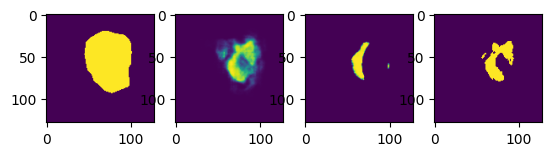

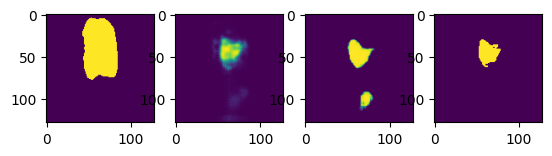

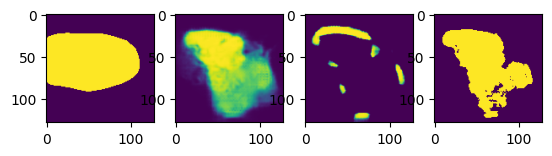

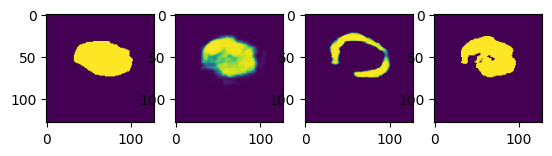

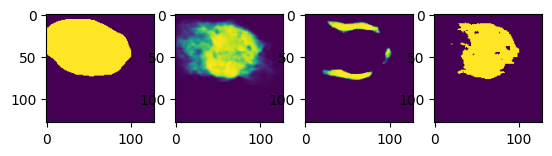

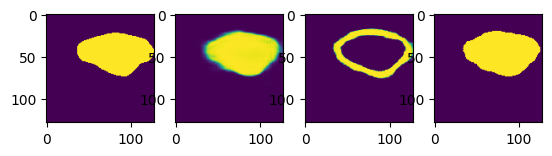

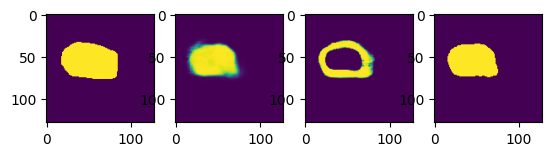

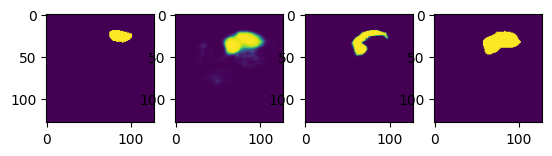

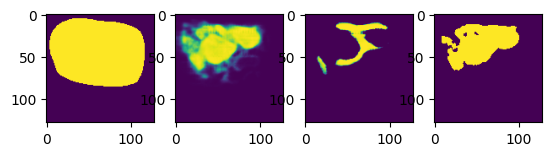

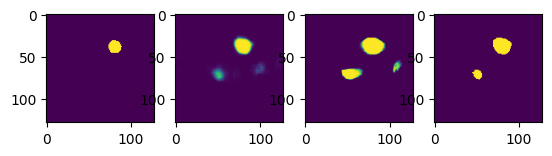

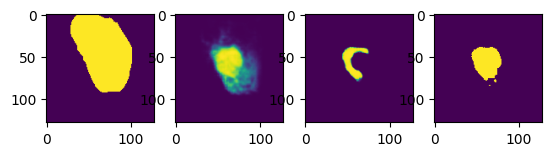

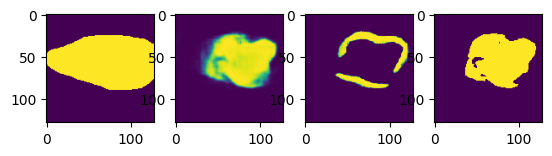

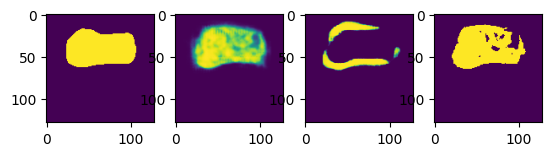

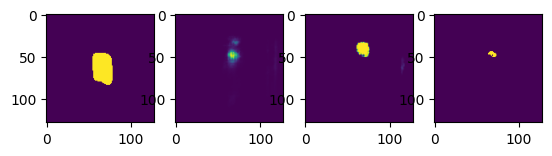

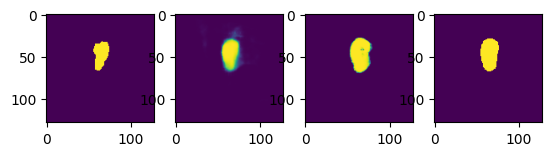

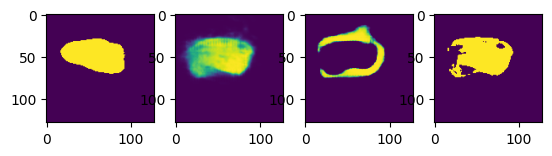

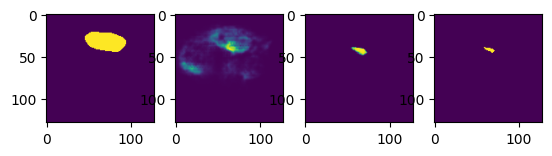

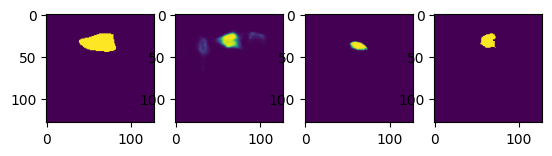

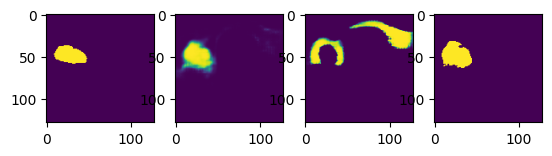

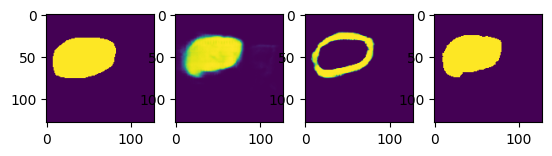

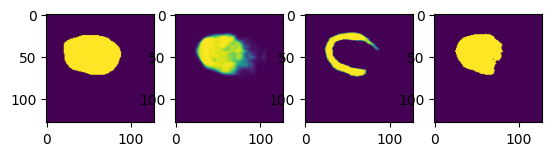

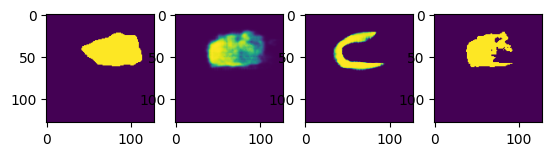

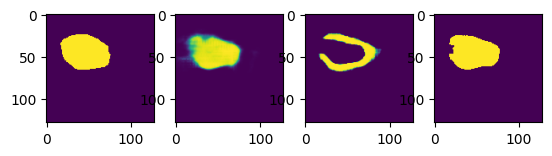

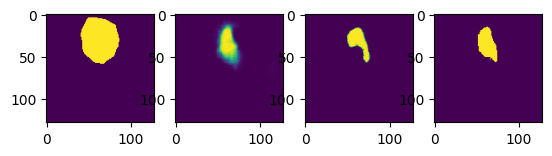

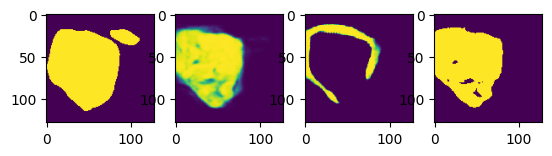

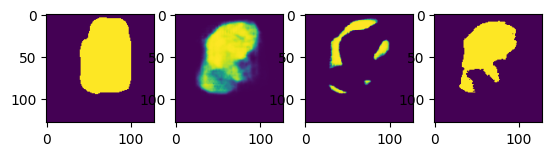

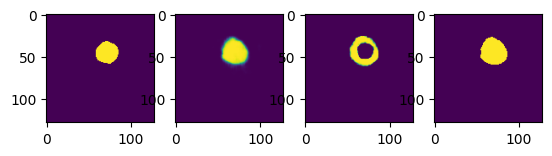

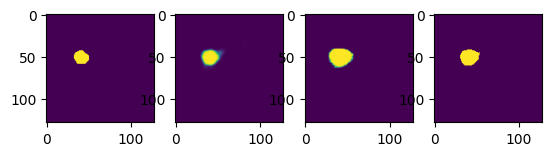

In [51]:
for i in range(nodule_image_mask.shape[0]):
    index = i
    plt.subplot(1,4,1)
    plt.imshow(nodule_image_mask[index][0].detach().cpu().numpy())
    plt.subplot(1,4,2)
    plt.imshow(sig_nodule_image_pred[index][0].detach().cpu().numpy())
    plt.subplot(1,4,3)
    plt.imshow(sig_nodule_contour_pred[index][0].detach().cpu().numpy())
    plt.subplot(1,4,4)
    plt.imshow(refined_mask[index][0].detach().cpu().numpy())
    plt.show()